In [1]:
import torch
from torch import nn
from collections import OrderedDict
import numpy as np

In [31]:
class CoDA_AE(nn.Module):
    
    def __init__(self, input_dim, dimension, encoder_shape, decoder_shape):
        super(CoDA_AE, self).__init__()
        
        #define a list with each element the input and output dim of the layer
        layer_list = [[encoder_shape[i], encoder_shape[i+1]] for i in range(0, len(encoder_shape)-1)]
        
        encoder_dict = OrderedDict()
        
        #first layer will be twice input size, since we are feeding in both c_kl and X 
        encoder_dict["layer0"] = nn.Linear(2 * input_dim, encoder_shape[0])

        for i in range(0,len(encoder_shape)-1):
            encoder_dict["layer"  + str(i)] = nn.Linear(encoder_shape[i], encoder_shape[i+1])
            encoder_dict["layer_ac"  + str(i)] = nn.ELU()
        encoder_dict["final_layer"] = nn.Linear(encoder_shape[-1], dimension)


        self.encoder = nn.Sequential(encoder_dict)
        
        layer_list = [[decoder_shape[i], decoder_shape[i+1]] for i in range(0, len(decoder_shape)-1)]
        
        decoder_dict = OrderedDict()
        decoder_dict["layer0"] = nn.Linear(dimension, decoder_shape[0])

        for i in range(0,len(decoder_shape)-1):
            decoder_dict["layer"  + str(i)] = nn.Linear(decoder_shape[i], decoder_shape[i+1])
            decoder_dict["layer_ac"  + str(i)] = nn.ELU()

        #final layer will map back to input dim
        decoder_dict["final_layer"] = nn.Linear(decoder_shape[-1], input_dim)
        decoder_dict["final_ac"] = nn.ELU()

        self.decoder = nn.Sequential(decoder_dict)
        
        
    def forward(self,x):
        #run the encoding and store the low level representation as A
        x_ckl = torch.log(check(x))
        
        #pass in both x and x_ckl as per paper
        self.A = self.encoder(torch.cat((x, x_ckl), 1))
        self.reconstruction = self.decoder(self.A)
        return self.reconstruction
        

In [16]:
class CoDA_Loss(torch.nn.Module):
    
    def __init__(self):
        super(CoDA_Loss,self).__init__()
        
    def forward(self,Y,X):
        #X is original data, Y is CoDA reconstruction
        #input needs to be normalised by g(x) (geometric mean) for X_hat
        #TODO centering matrix? Reduce mean? Mask?  
        X_check = check(X)
        coda_loss = torch.sum(torch.exp(Y)) - torch.sum(X_check * Y)
        return coda_loss

def check(X):
    #assume input is tensor so we can use the numpy() method
    assert type(X) == torch.Tensor
    gmean = torch.prod(X, 1) ** (1./X.shape[1])
    return torch.div(X.t(), gmean).t()

In [5]:
C = CoDA_Loss()
C.forward(torch.FloatTensor([[2,2,2,4], [1,3,3,4], [1,4,3,4]]), torch.FloatTensor([[2,2,3,4], [1,1,1,1], [1,4,3,4]]))

tensor(267.8988)

CoDA_AE(
  (encoder): Sequential(
    (layer0): Linear(in_features=6, out_features=100, bias=True)
    (final_layer): Linear(in_features=100, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (layer0): Linear(in_features=2, out_features=3, bias=True)
    (final_layer): Linear(in_features=3, out_features=3, bias=True)
    (final_ac): ELU(alpha=1.0)
  )
)
epoch 1000, loss -284.4277038574219
epoch 2000, loss -288.76629638671875
epoch 3000, loss -288.8765869140625
epoch 4000, loss -288.9192199707031
epoch 5000, loss -288.9458923339844
epoch 6000, loss -288.9624938964844
epoch 7000, loss -288.9730224609375
epoch 8000, loss -288.9794006347656
epoch 9000, loss -288.9835510253906
epoch 10000, loss -288.98602294921875


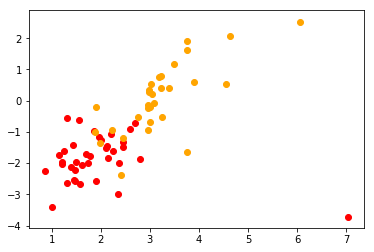

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt

data_9 = pd.read_csv("Data 9. Urinary excretions (mg_per_24hr) of steroid metabolites for 37 adults and 30 normal children.csv")
adult_inds = np.where(data_9['Adult/Child'] == 'A')
child_inds = np.where(data_9['Adult/Child'] == 'C')

adult = data_9.to_numpy()[adult_inds]
child = data_9.to_numpy()[child_inds]
features = data_9[data_9.columns[2:]].to_numpy()


features = np.array([feat/sum(feat) for feat in features])



X = features
autoencoder = CoDA_AE(X.shape[1], 2, [100,], [3,])
print (autoencoder)
#define the CoDA-PCA loss
loss_function = CoDA_Loss()
optim = torch.optim.SGD(autoencoder.parameters(), lr = 0.0001)
    
for epoch in range(0,10000):
    out = autoencoder.forward(torch.FloatTensor(X))
    loss = loss_function(out, torch.FloatTensor(X))
        
    optim.zero_grad()
        
    loss.backward()
    optim.step()
        
    epoch += 1
    
    if (epoch % 1000 == 0):
        print("epoch {}, loss {}".format(epoch, loss))
    
test = autoencoder.A.detach().numpy()



# # pca_clr = CodaPCA.CLRPCA(2)
# # pca_clr.fit(features)
# # test = pca_clr.transform(features)

# pca = CodaPCA.CodaPCA(2,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
# pca.fit(features)


# test = pca.transform(features)

plt.scatter(x = test[adult_inds][:,0], y = test[adult_inds][:,1], c ="red")
plt.scatter(x = test[child_inds][:,0], y = test[child_inds][:,1], c ="orange")


plt.show()
